# Project 8 - the Atlantic Multidecadal Oscillation
Maelle Humblet (IUEM) et Tobias Baumgartner (IMT)



The aim of this notebook is to give you some information that might be useful for starting your projects: 

- Part A provides you with a quick introduction to the CMIP6 project and ensemble modelling. It also contains a list of links that provide details about the data that are available to you in the CMIP6 catalogue. You can use this to help you to decide what data you want to analyse for your project.
- Part B is the project work

## A. Data sources and information about CMIP6

### 1. Introduction
Projects 7 & 8 require you to analyse model output from the CMIP6 project. It is possible to access these data a number of ways, including via the cloud, since Google host a part of these data via their Public Datasets programme (https://cloud.google.com/blog/products/data-analytics/new-climate-model-data-now-google-public-datasets). For your projects, this is how you will access the CMIP6 data. As you saw last week in class, this method means that you will be able to analyse the data directly in Colab without downloading anything to your machine.

### 2. What is ensemble modelling and why do we do it?
CMIP6 uses an ensemble modelling strategy. What does this mean?

In the context of CMIP6, an ensemble of model simulations is simply a collection of simulations that have been created using exactly the same configuration for everything, with the exception of the initial conditions. These small differences in the initial state can lead to much larger differences in the forecast over time (as popularised in the so-called "butterfly effect", for example).

We use ensemble modelling to help us understand the probability of the events simulated by the model occurring. For example, imagine that we use an ensemble of 5 simulations to try to forecast next week's weather, and all 5 simulations predict that it will rain in Brest. In this case, we will be more likely to believe that it will rain next week than if our results had been that 2 of our simulations told us that it would rain, 2 told us that it would be sunny and 1 told us that it would snow.

The aim of the ensemble approach in climate modelling (as in CMIP6) is the same as in the weather forecasting case: it lets us quantify how much we believe a given prediction of the future climate.

### 3. What is CMIP6?
CMIP = Coupled Model Intercomparison Project (wikipedia page: https://en.wikipedia.org/wiki/Coupled_Model_Intercomparison_Project)

The CMIP programme aims to improve our knowledge of climate change. It began in 1995, and has already been through 5 "phases". Each "phase" corresponds to a coordinated effort to collect together a number of climate simulations, created by research centres around the world. These simulations are then made freely available for anybody to download and analyse. Phase 6 is now underway: the data that you will be analysing are thus only recently available, and are likely to be used in research studies for about the next ten years or so.

A number of experiments are defined at each phase. These often consist of "historical" experiments, which simulate the climate over the past decade, and a number of future experiments, which simulate the future climate in response to certain prescribed greenhouse gas concentration scenarios, which should represent the response to possible future decisions made by society. (If you are interested in reading more about these, this article provides a nice introduction: https://www.carbonbrief.org/explainer-how-shared-socioeconomic-pathways-explore-future-climate-change)

### 4. What data are available for your projects?
The CMIP6 catalogue contains a lot of data: the entire archive may eventually comprise 20PB of data when all the simulations have been completed! Not all of this data is available yet, and not all available data is stored in the Cloud, so you will need to check to see what is available when deciding which model(s) and scenario(s) you want to analyse.

The people at Pangeo have written some useful summaries that describe:

- the data available in the Cloud: https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q/edit
- a list of the models available: https://docs.google.com/spreadsheets/d/13DHeTEH_8G08vxTMX1Fs-WbAA6SamBjDdh0fextdcGE/edit#gid=165882553
- a list of the variables available: https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y/edit#gid=1221485271

They have also produced an example notebook that shows how to load in air temperature. You can either run it via Binder on the Pangeo infrastructure: https://binder.pangeo.io/v2/gh/pangeo-data/pangeo-cmip6-examples/master or run it directly in Colab: https://colab.research.google.com/drive/19iEVxE_9QoTeg4st7MmucHJUmO93NXHp

Their notebook is an excellent introduction: it should provide you with everything that you need to get started loading the data. I recommend that you look at it!

## B. Code

In [0]:
# first we have to install some libraries in Colab
!pip install zarr
!pip install gcsfs
!apt-get -qq install python-cartopy python3-cartopy

In [0]:
# general setup
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from scipy import signal # for periodogram


#from dask_ml.decomposition import PCA
from sklearn.decomposition import PCA
# import the LinearRegression method from scikit-learn
from sklearn.linear_model import LinearRegression

# set up cartopy
import cartopy.crs as ccrs
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

# notebook display options
xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

tos = Sea Surface Temperature	of table_id = Omon

Omon = Ocean monthly data

RCP = Representative Concentration Pathway

SSP = Shared Socioeconomic Pathways

ssp245	update of RCP4.5 based on SSP2	2015	2100	ScenarioMIP	1	86

## Definition of functions


In [0]:
# length of the the rolling average filter
rollLen = 60

In [0]:
def getData(query):
    df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
    df= df.query(query)
    # setup the gcs access
    gcs = gcsfs.GCSFileSystem(token='anon')

    # get the path to a specific zarr store (the first one from the dataframe above)
    zstore = df.zstore.values[-1]

    # create a mapping interface to the store
    mapper = gcs.get_mapper(zstore)

    # open it using xarray and zarr
    dt = xr.open_zarr(mapper, consolidated=True)

    return dt

In [0]:
def plotMeanSST(tos, string):

  tos_mean= tos.mean('y').mean('x')
  tos_mean = tos_mean.rolling(time=rollLen  , center=True).mean()
  

  # plot
  plt.plot_date(tos.time,tos_mean,'-',label=string)
  plt.xlabel('Time',fontsize=15)
  plt.ylabel('Mean SST',fontsize=15)
  plt.legend()

In [0]:
def selNAS(dt):
   # select North Atlantic Sea
  na=dt.sel(y=slice(200,310), x=slice(190, 280))
  return na


In [0]:
def getTrend(tos):
  # create a generic instance the model
  model = LinearRegression()

  tim = np.arange(0,len(tos.time))
  # fit the model
  # (we have to add [:,None] because the method expects to receive 2D arrays as input data)
  model.fit(tim[:,None], tos.mean('y').mean('x').values[:,None])

  # get the predicted values of ŷ using the model:
  tos_trend = model.predict(tim[:,None])
  tos_trend=xr.DataArray(tos_trend.squeeze(),dims=('time'),coords={'time':tos['time']})
  return tos_trend

In [0]:
#  Calculate the mean value of the region and substract the global se
def AMOana(dt,string):

  global_tos_mean = dt.tos.mean('y').mean('x')

  na = selNAS(dt)

  nas_tos_corrected = na.tos - global_tos_mean # on enleve la moyenne globale

  tos_trend = getTrend(nas_tos_corrected)

  nas_tos_corrected = nas_tos_corrected  - tos_trend # on enleve la tendance

  plotMeanSST(nas_tos_corrected,string)
  plt.legend()
  return tos_trend, nas_tos_corrected

In [0]:
def PCAana(tos, Ncs):
  v = tos.rolling(time=rollLen  , center=True).mean().stack(features=('x','y'))
  v = v[np.int(np.ceil(rollLen/2)):-np.int(np.ceil(rollLen/2))]
  v=v.fillna(0)
  # Instantiate the PCA:
  reducer = PCA(n_components=Ncs, random_state=10)
  # Compute eigen vectors of the covariance matrix:
  reducer.fit(v)
  # Number of components retained (the new dimensions of the reduced array)
  Nc = reducer.n_components_

  # Eigen vectors (maps defining the the new/reduced space):
  P = reducer.components_ # [Nc , n_features], the P matrix


  # Amount of variance explained by each eigen vectors (with 0 to 1 values):
  eVar= reducer.explained_variance_ratio_

  # Compute eigen values (ie the time series with intensity of each eigen vectors in this dataset):
  y = reducer.transform(v)

  # create Xarrays
  P = xr.DataArray(P,dims=('Nc','features'),coords={'Nc':range(0,Ncs),'features':v['features']})
  P = P.unstack('features')
  P = P.assign_coords(nav_lon = tos.nav_lon, nav_lat = tos.nav_lat)

  y = xr.DataArray(y,dims=('time','Nc'),coords={'time':v['time'],'Nc' : range(0,Ncs)})



  # plot

  plt.figure(figsize=(15,3))

  plt.subplot(1,3,1)
  P.sel(Nc=0).plot(x = 'x', y='y')


  plt.subplot(1,3,2)
  #y[np.int(np.ceil(rollLen/2)):-np.int(np.ceil(rollLen/2))].sel(Nc=0).plot()
  y.sel(Nc=0).plot()
  plt.subplot(1,3,3)

  plt.bar(range(0,Ncs),eVar*100)
  plt.title('Variance by component')
  plt.xlabel('Component (Nc)')

  # finally, we add the coastlines

  return y,P, Nc, eVar, reducer, Ncs

In [0]:
def plotSpectre(na):
  na = na.mean('x').mean('y')
  na = na.rolling(time=rollLen  , center=True).mean() - na.mean()
    
  #na = na - na.mean()
  
  f, spectre = signal.periodogram( na.dropna(dim='time'),fs = 1)
  spectre.shape
  plt.plot(1/f/12,spectre*f)

  plt.ylim([0,0.04])
  plt.xlabel('Period (yr)')
  plt.ylabel('Power')
 

## Analyse data


### Get the data


In [0]:

na_126 = getData("activity_id=='ScenarioMIP' & table_id == 'Omon' & variable_id == 'tos' & experiment_id == 'ssp126' & institution_id == 'IPSL' ")
na_245= getData("activity_id=='ScenarioMIP' & table_id == 'Omon' & variable_id == 'tos' & experiment_id == 'ssp245' & institution_id == 'IPSL' ")
na_585 = getData("activity_id=='ScenarioMIP' & table_id == 'Omon' & variable_id == 'tos' & experiment_id == 'ssp585' & institution_id == 'IPSL' ")

### Plot the time series of the mean sst in the north atlantic sea

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'Mean SST in the north atlantic sea')

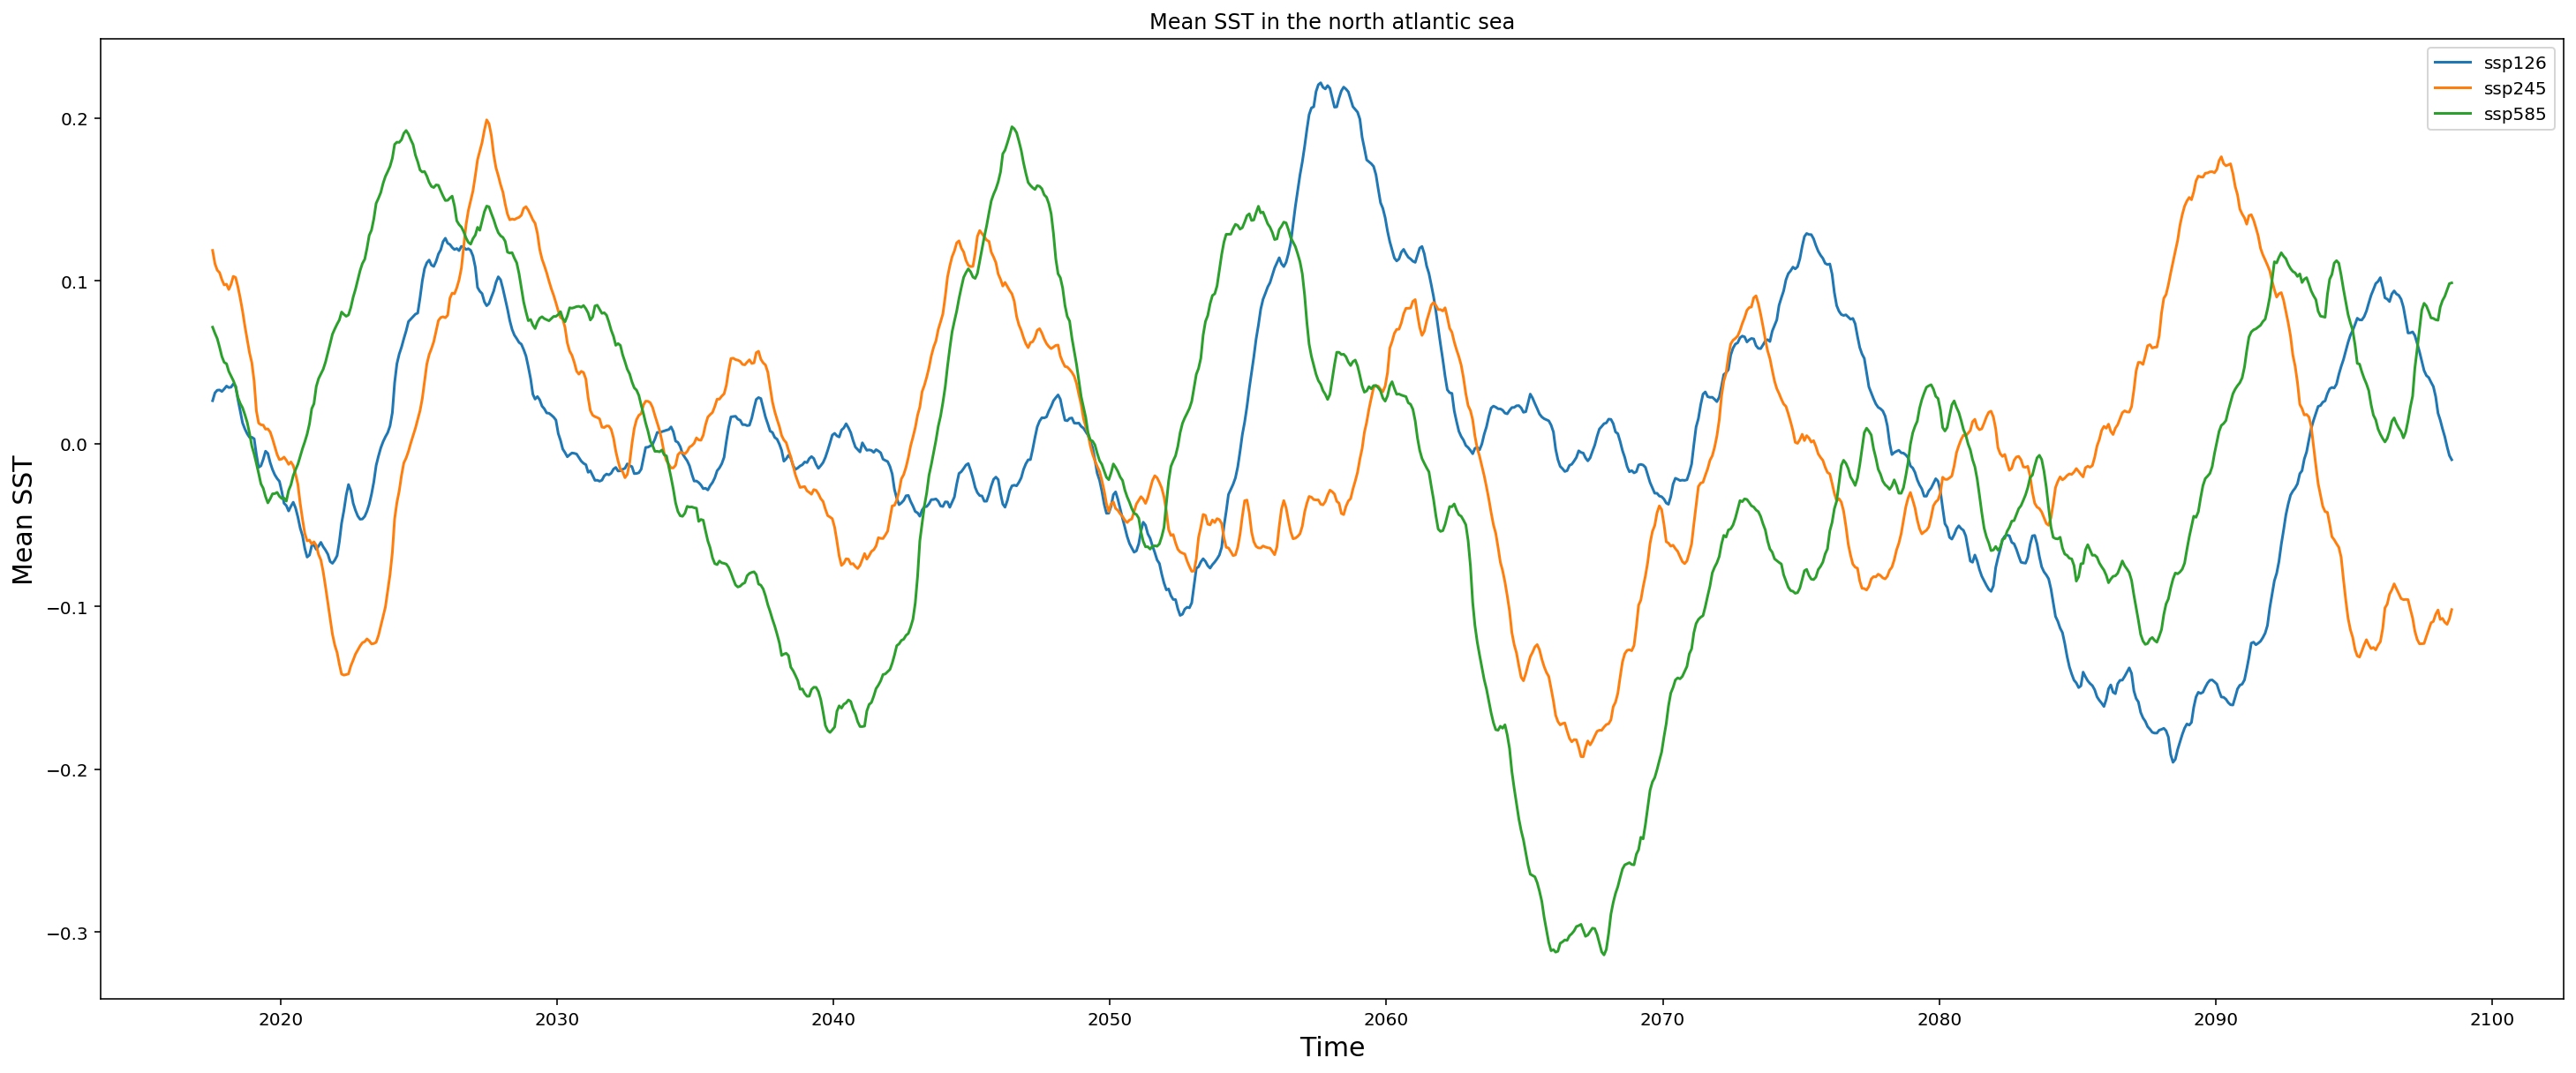

In [357]:
plt.figure(figsize=(25,10))

tos_trend_126,na_corr_126=AMOana(na_126,'ssp126')
tos_trend_245,na_corr_245=AMOana(na_245,'ssp245')
tos_trend_585,na_corr_585=AMOana(na_585,'ssp585')

plt.title("Mean SST in the north atlantic sea")



Text(0.5, 1.0, 'Trends after correcetion by global trend')

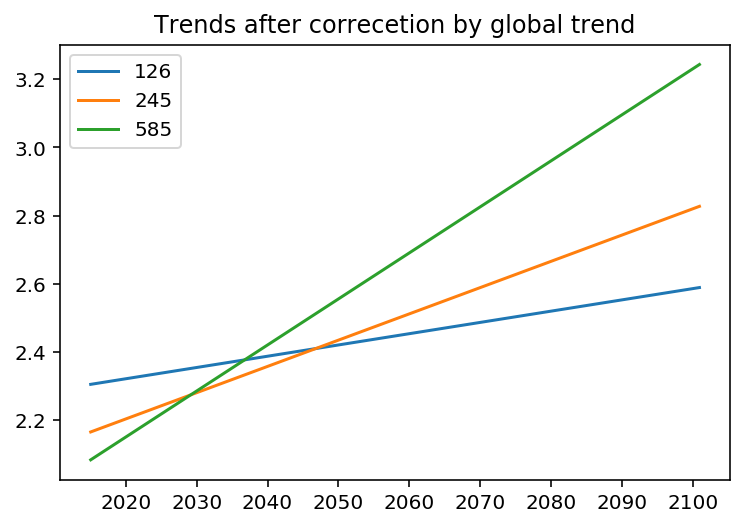

In [0]:
#plot the trends without global mean

plt.plot(na_126.time,tos_trend_126,label='126')
plt.plot(na_245.time,tos_trend_245,label='245')
plt.plot(na_585.time,tos_trend_585,label='585')
plt.legend()
plt.title("Trends after correcetion by global trend")

## Principal component analysis

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.p

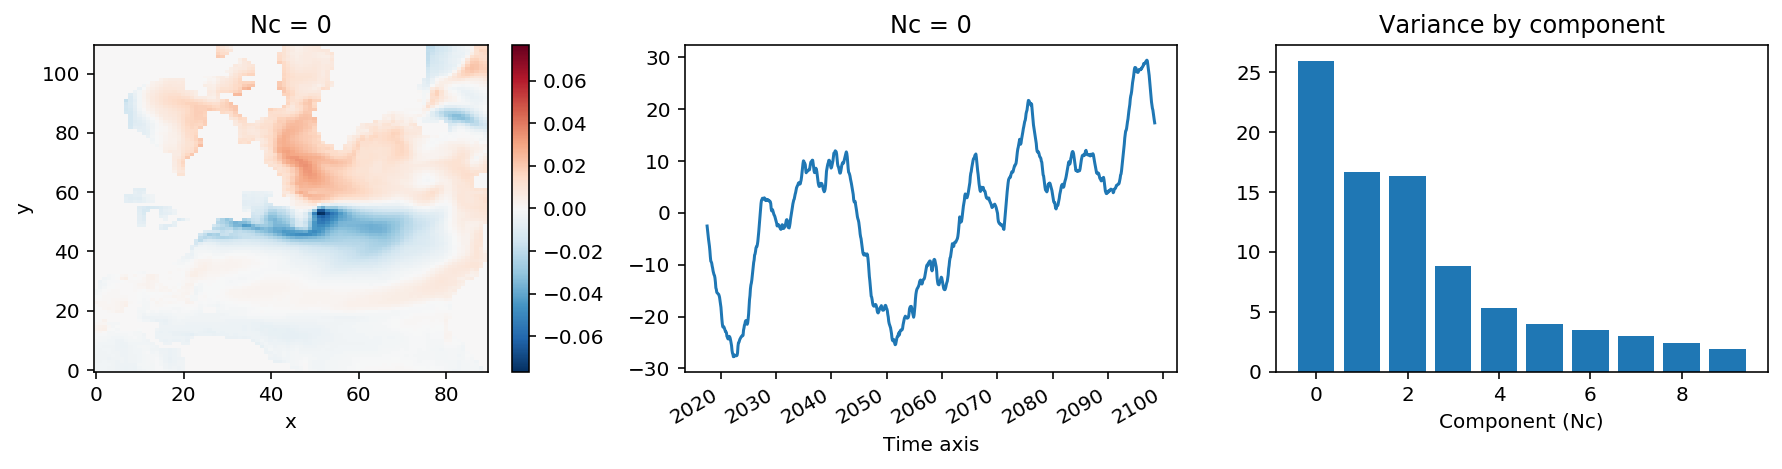

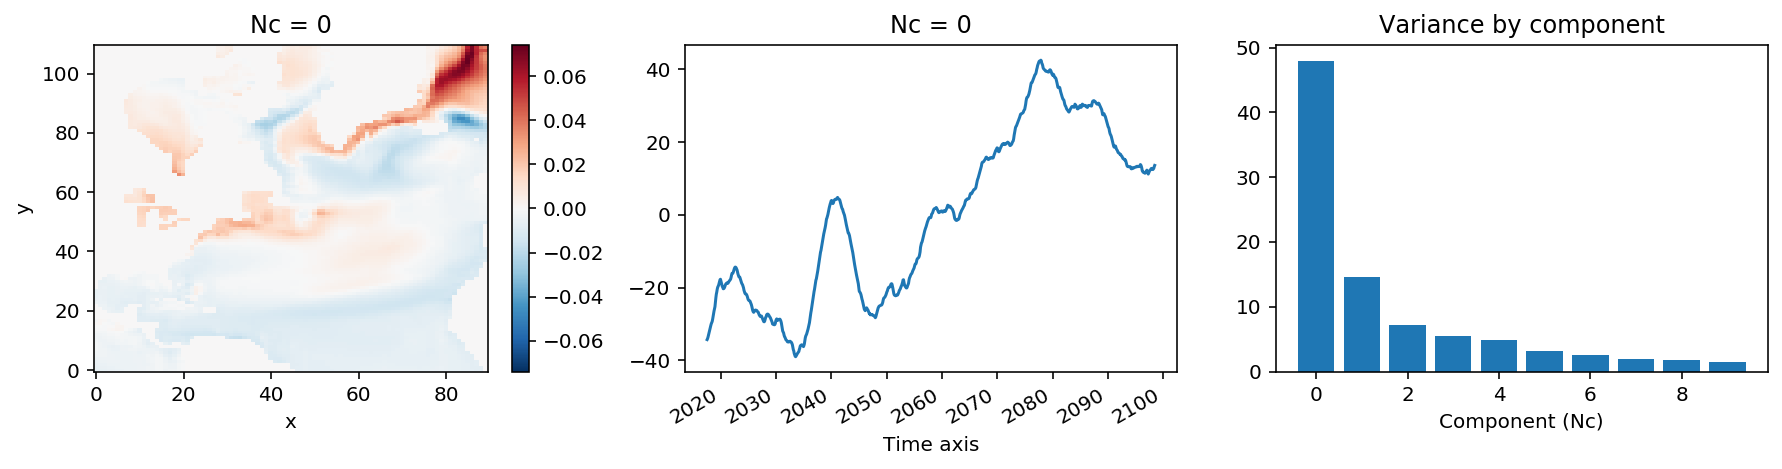

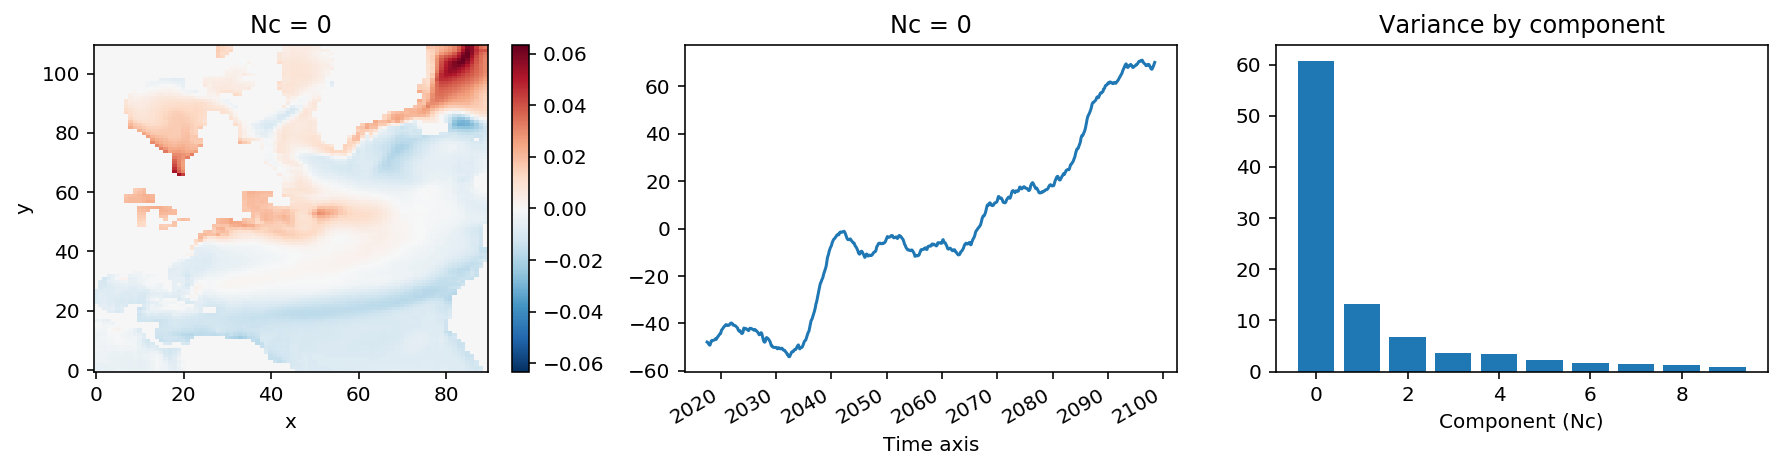

In [402]:
#PCA
Ncs = 10 # number of components

y_126,P_126, Nc_126, eVar_126, reducer_126, Ncs_126 = PCAana(na_corr_126,Ncs)

y_245,P_245, Nc_245, eVar_245, reducer_245,Ncs_245 = PCAana(na_corr_245,Ncs)

y_585,P_585, Nc_585, eVar_585, reducer_585, Ncs_585 = PCAana(na_corr_585,Ncs)


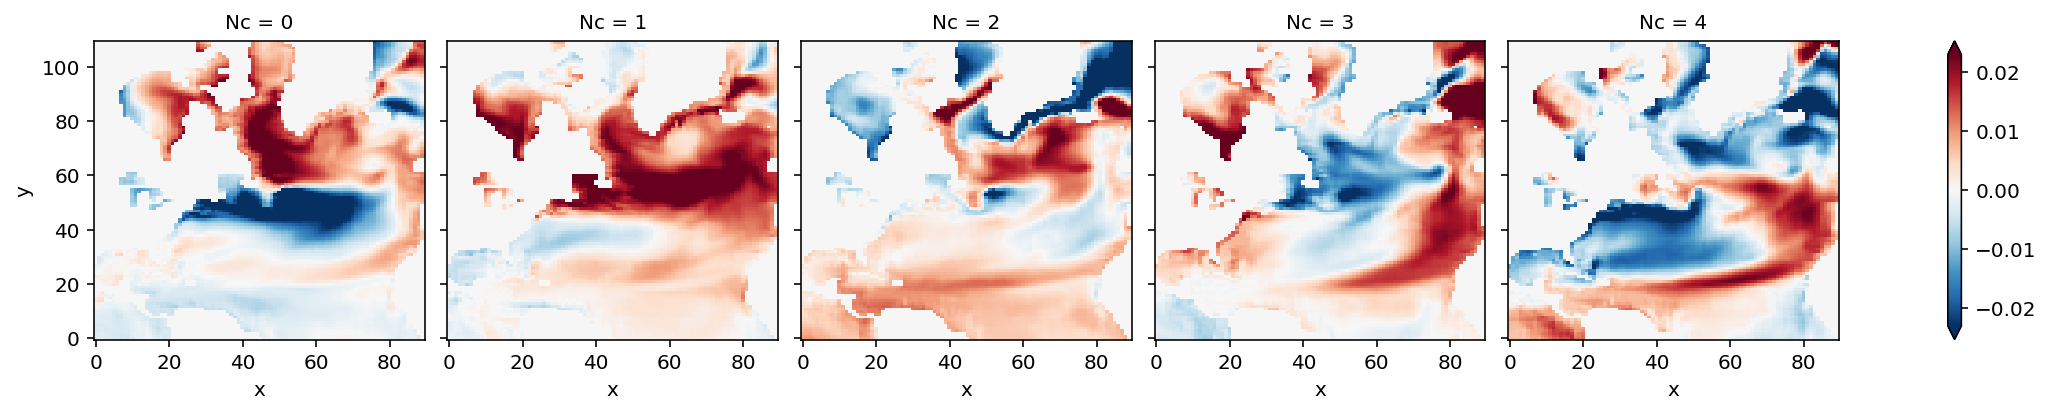

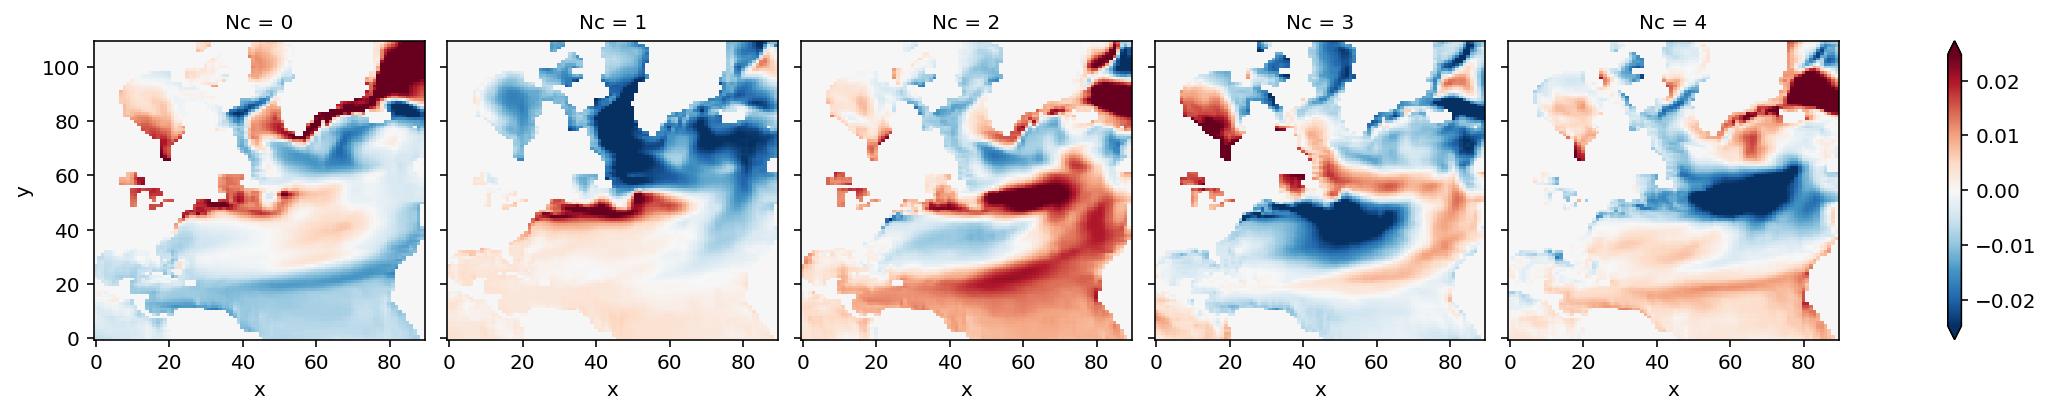

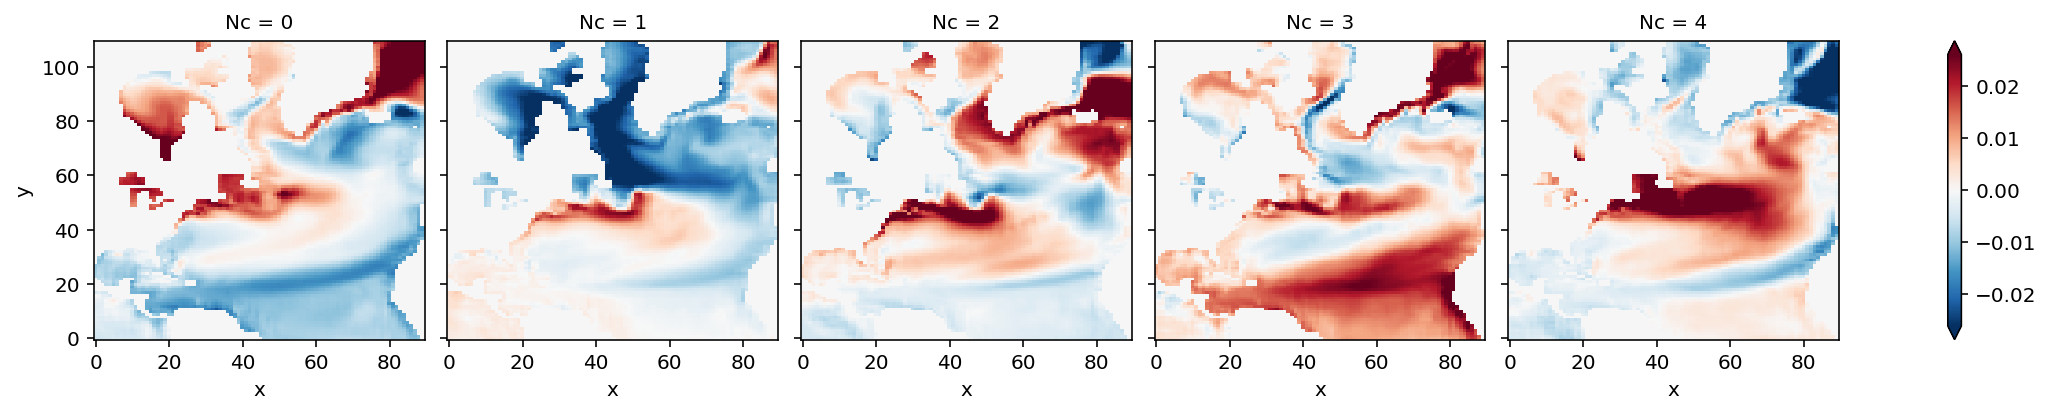

In [403]:

P_126.sel(Nc=slice(0,4)).plot(x='x', y='y', col='Nc', col_wrap=5, robust=True)

P_245.sel(Nc=slice(0,4)).plot(x='x', y='y', col='Nc', col_wrap=5, robust=True)

P_585.sel(Nc=slice(0,4)).plot(x='x', y='y', col='Nc', col_wrap=5, robust=True)

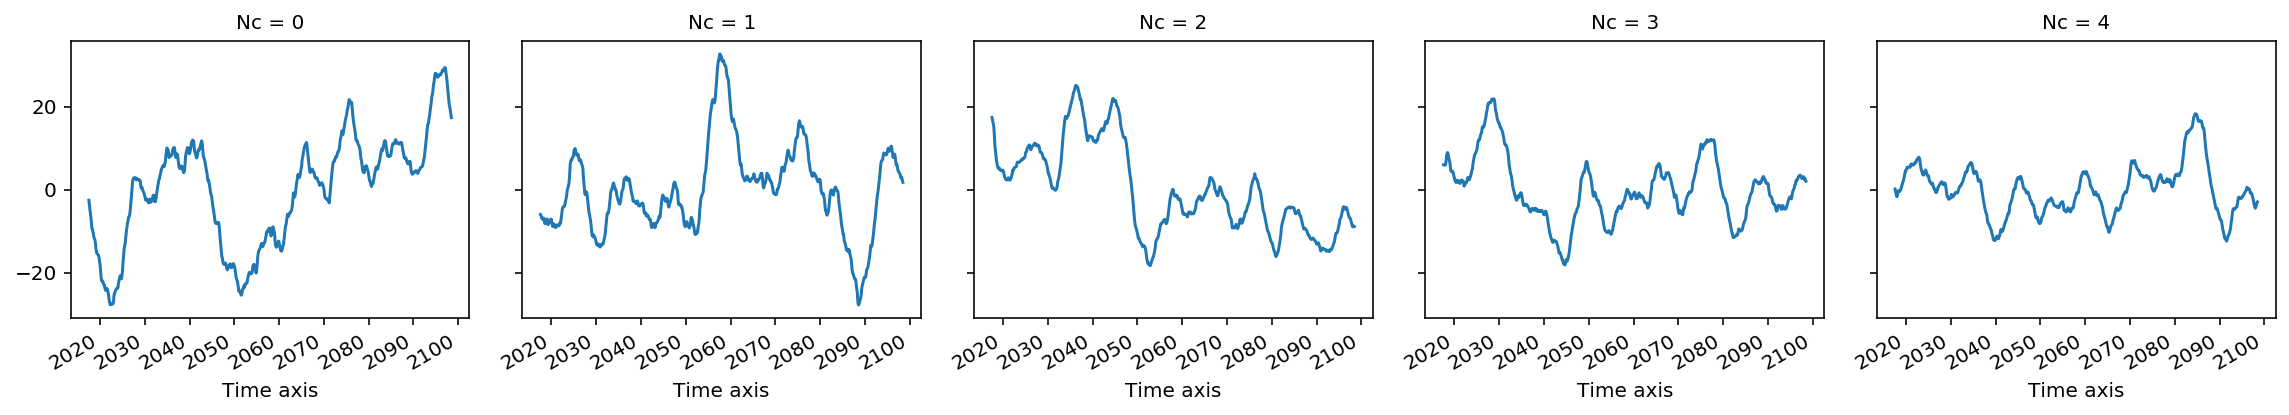

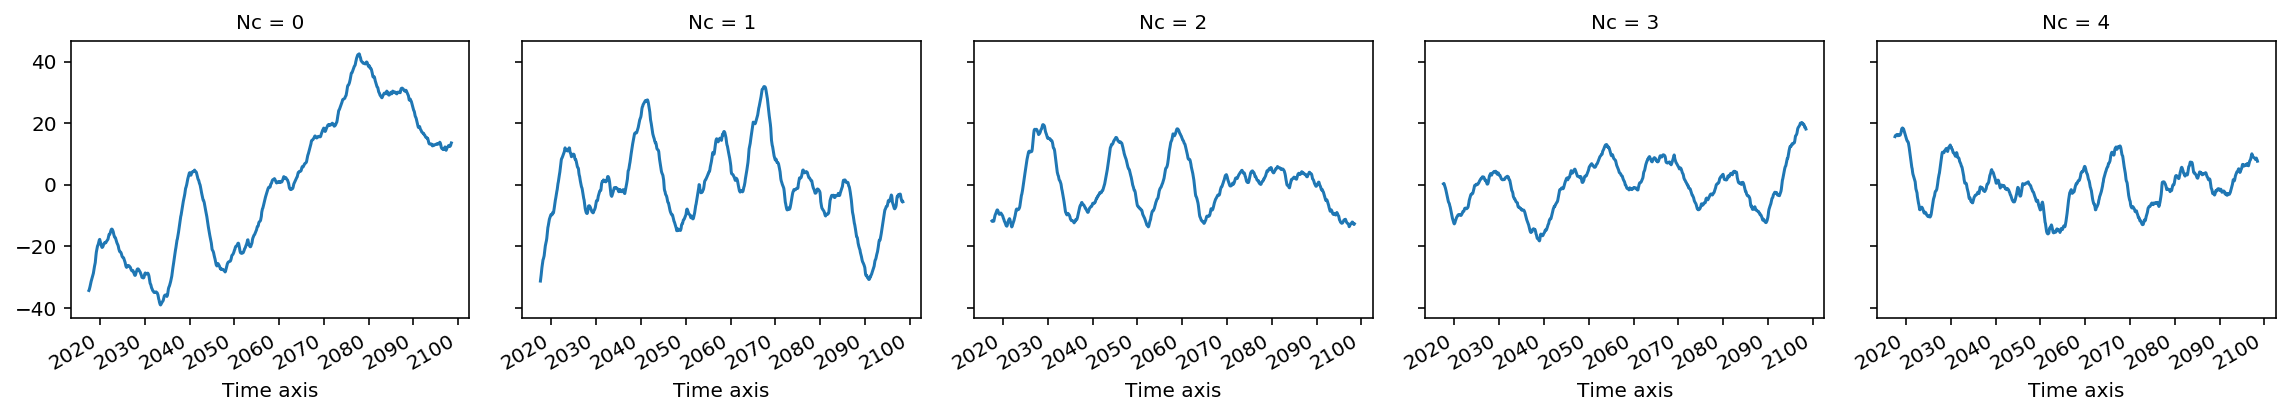

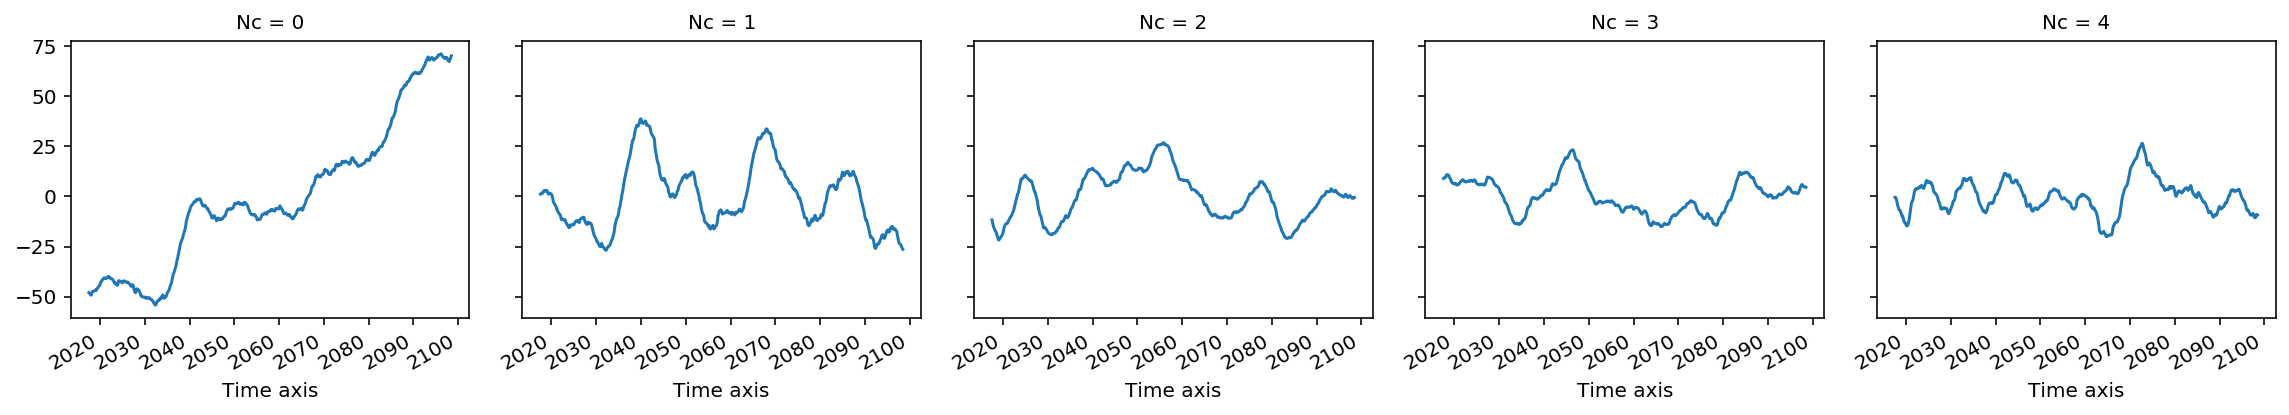

In [404]:
y_126.sel(Nc=slice(0,4)).plot( col='Nc', col_wrap=5)
y_245.sel(Nc=slice(0,4)).plot( col='Nc', col_wrap=5)
y_585.sel(Nc=slice(0,4)).plot( col='Nc', col_wrap=5)

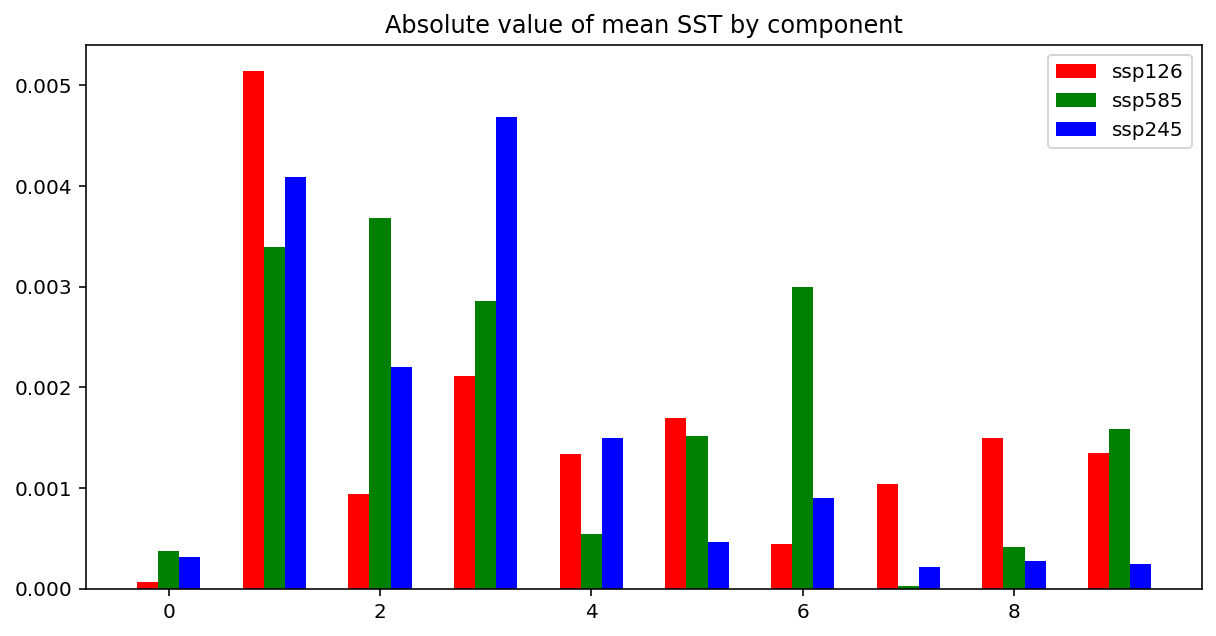

In [399]:

plt.figure(figsize=(10,5))
plt.bar(np.arange(Ncs)-0.2,np.abs(P_126.mean('x').mean('y')),width=0.2, color='r', align='center')
plt.title("Mean SST by component")

plt.bar(np.arange(Ncs), np.abs(P_245.mean('x').mean('y')),width=0.2, color='g', align='center')
plt.title("Mean SST by component")

plt.bar(np.arange(Ncs)+0.2,np.abs(P_585.mean('x').mean('y')),width=0.2, color='b', align='center')
plt.title("Absolute value of mean SST by component")

plt.legend({'ssp126','ssp245','ssp585'})

## STD between 3 models (time averaged)

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'STD between 3 models time averaged')

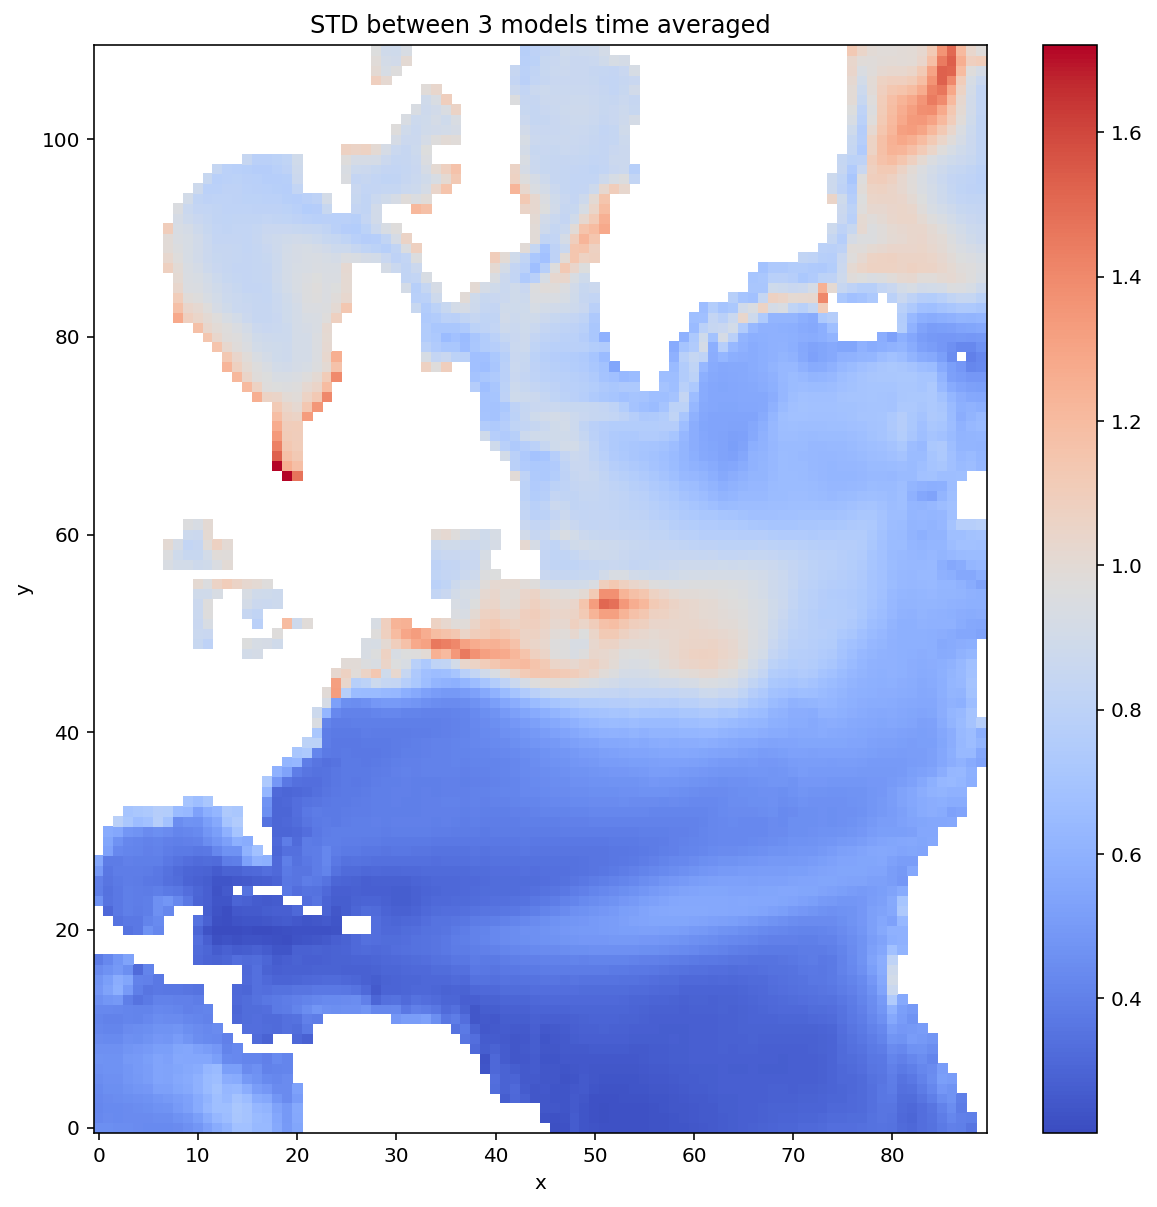

In [0]:
# combine the diffrent models into one Xarray


plt.figure(figsize=(10,10))
na=xr.concat((na_corr_585,na_corr_245,na_corr_126),dim='models')
na_std = na.std(dim='models')
na_std.mean(dim='time').plot(cmap='coolwarm')
plt.title('STD between 3 models time averaged')


/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


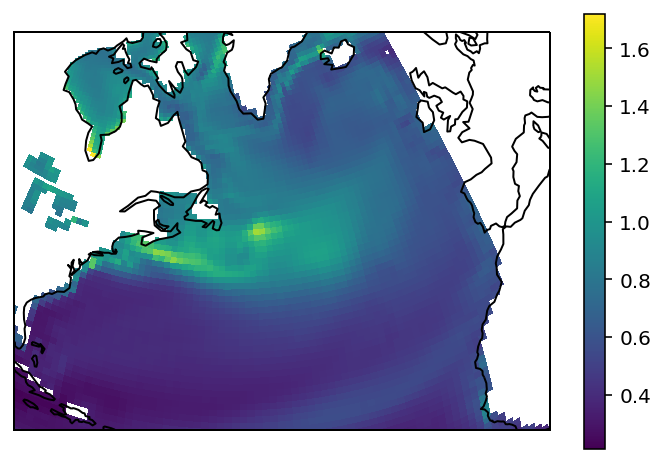

In [0]:
#with projection
# select the projection that we want
ax = plt.axes(projection=ccrs.Orthographic(-50,55,));
# then we set the latitude/longitude limits on our figure
ax.set_extent([-80, -5, 20, 65], ccrs.PlateCarree())
# plot the data using xarray
na_std.mean(dim='time').plot.pcolormesh(ax=ax,transform=ccrs.PlateCarree(),x='nav_lon', y='nav_lat', add_colorbar=True); 
# and finally add the coastlines
ax.coastlines();

Correlation between north atlantic avg sst et local sst 

In [0]:
# correlation between north atlantic avg sst et local sst 
# experimental !!!!!
card = na_corr_245.stack(features=('x','y')).values
reg = na_corr_245.mean('x').mean('y').values

conc = np.concatenate((card,reg[:,np.newaxis]),axis=1)

corrcm = np.corrcoef(conc.T)

corrcv = corrcm[0:-1,-1]

/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'Correlation coef between north atlantic avg sst et local sst ')

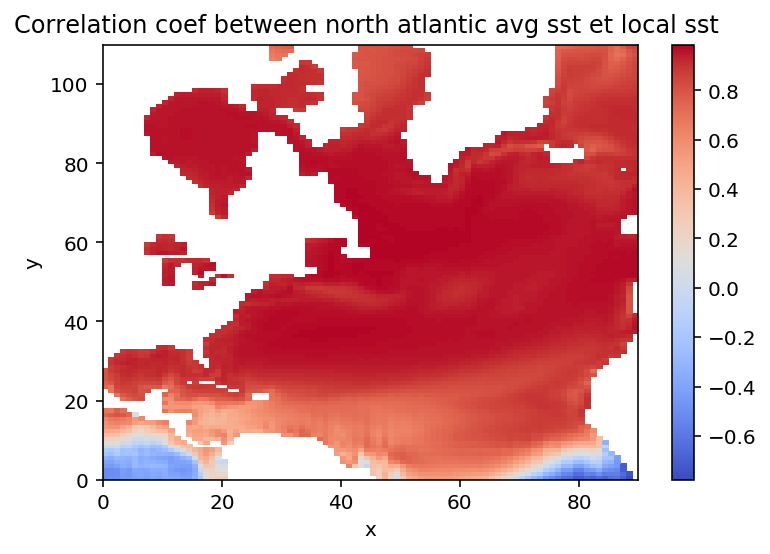

In [0]:
corrcre = corrcv.reshape((90,110))

plt.pcolor(corrcre.T,cmap='coolwarm')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Correlation coef between north atlantic avg sst et local sst ')

## Spectral analysis


/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.6/dist-packages/dask/array/numpy_compat.py:40:

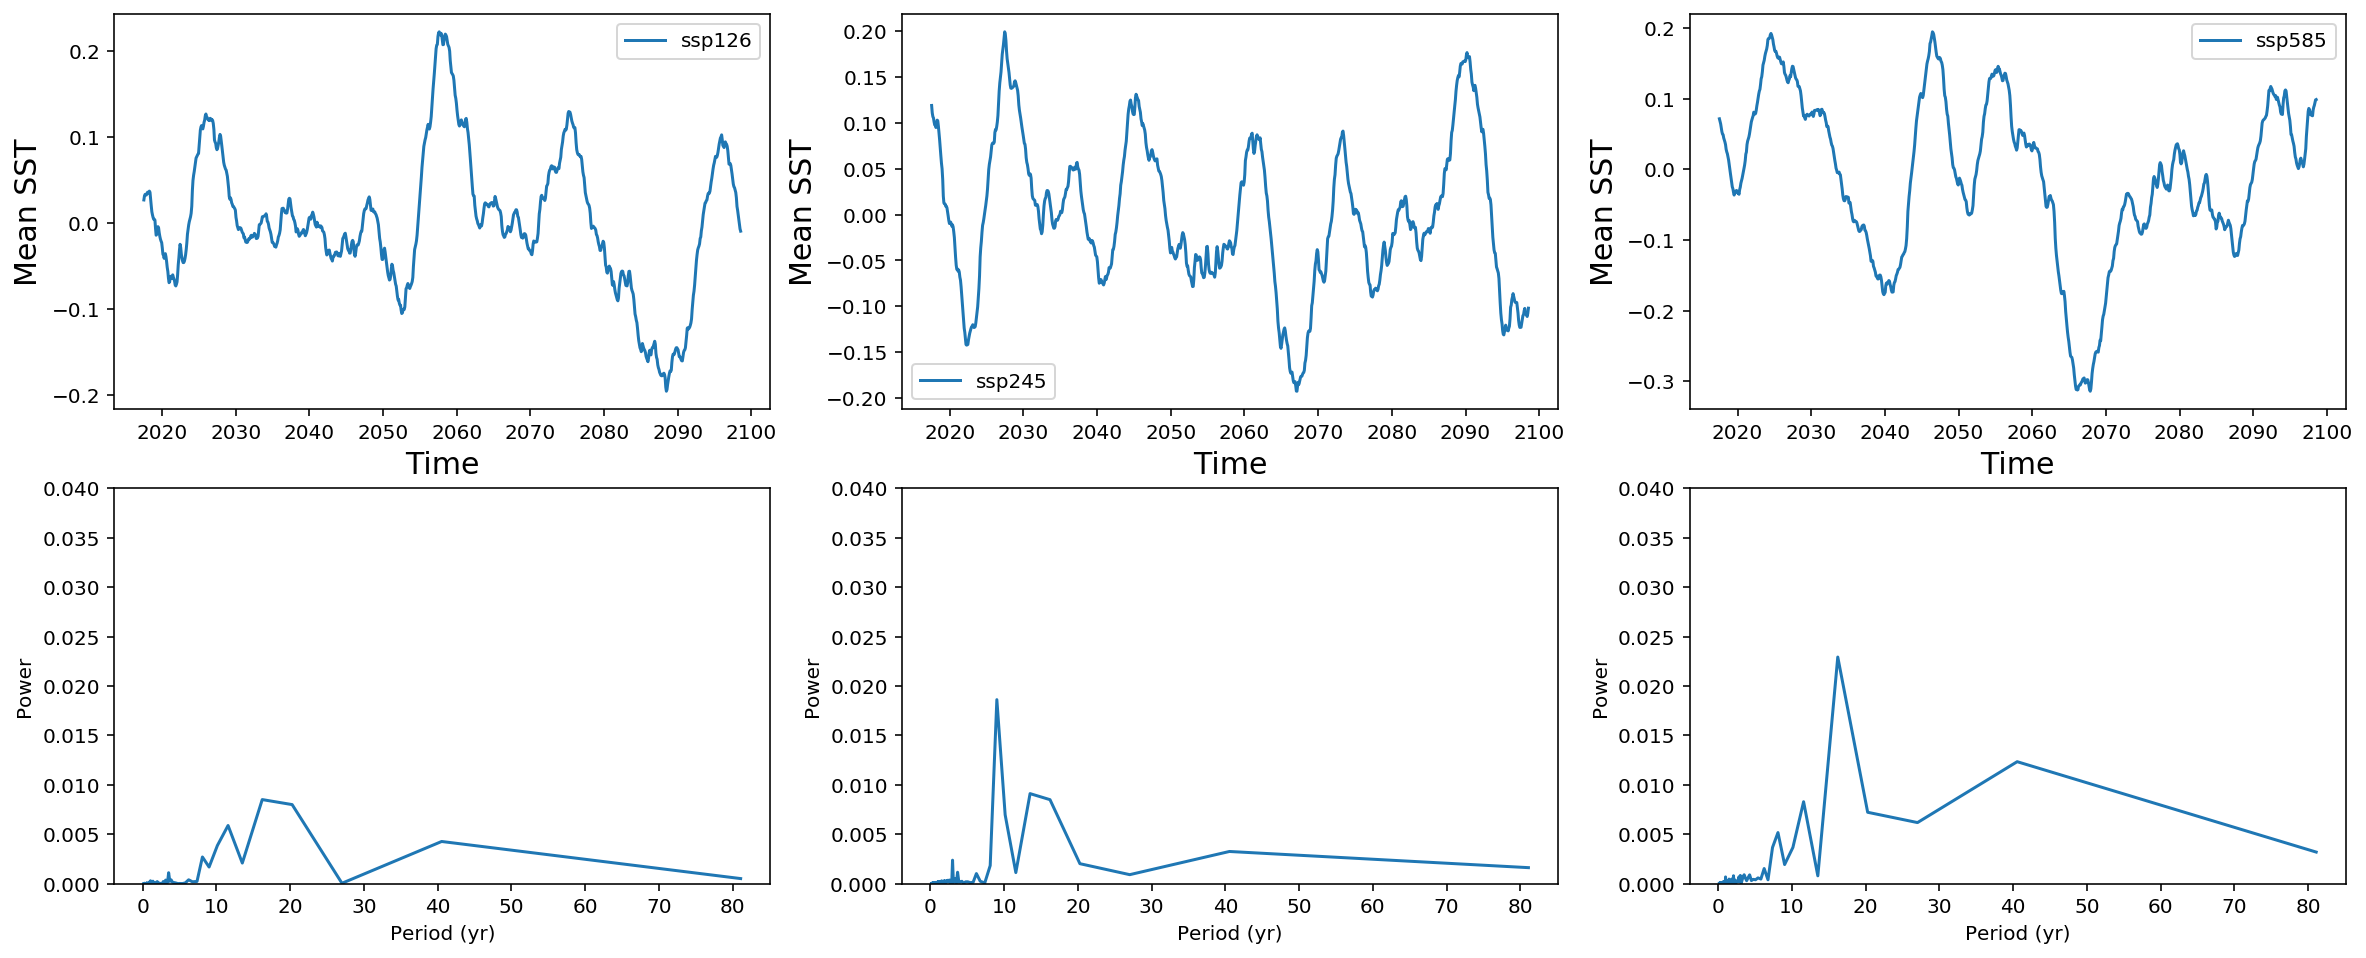

In [406]:

plt.figure(figsize=(20,8))
plt.subplot(2,3,1)
plotMeanSST(na_corr_126,'ssp126')
plt.subplot(2,3,4)
plotSpectre(na_corr_126)

plt.subplot(2,3,2)
plotMeanSST(na_corr_245,'ssp245')
plt.subplot(2,3,5)
plotSpectre(na_corr_245)

plt.subplot(2,3,3)
plotMeanSST(na_corr_585,'ssp585')
plt.subplot(2,3,6)
plotSpectre(na_corr_585)


